In [ ]:
import os
os.cpu_count()

4

NOTES:
- the databricks version is [here](https://community.cloud.databricks.com/?o=2722510497175539#notebook/802197639245970/command/850280873912051), with better visulization

# Advertising Analytics Click Prediction: SQL
####[Ad impressions with clicks dataset](https://www.kaggle.com/c/avazu-ctr-prediction/data)

<img src="/files/img/fraud_ml_pipeline.png" alt="workflow" width="500">

This is the SQL/Data exploration notebook for the series of Advertising Analytics Click Prediction notebooks.  For this stage, we will focus the Exploration of data.

In this notebook, the data are briefly analized to make sure it is ready for transformation and other preprocessing. The following steps are taken:
- checking data types, missing values (Nan or Null), cardinality of disinct values for each column
- Overall clicks vs no clicks
- within each feature/categorical variable:
    - compare clicks and no clicks, 
    - CTRs for different feature values. 
    - Specifically, The following feature are explored: banner_pos, 
device type, site category, hour of day, app category, c15. (Note two different SQL queries were used to achieve the same thing, refer to the queries in the beginning and in the end for them respectively.)

In [ ]:
first_time = True
!ls

sample_data


In [ ]:
if first_time:
  from google.colab import drive
  drive.mount("/content/drive")
  

Mounted at /content/drive


## Set up Spark


In [ ]:
if first_time:
  !apt-get update
  !apt-get install openjdk-8-jdk-headless -qq > /dev/null
  # !wget -q https://downloads.apache.org/spark/spark-2.4.7/spark-2.4.7-bin-hadoop2.7.tgz
  # !tar xf spark-2.4.7-bin-hadoop2.7.tgz
  !wget -q https://archive.apache.org/dist/spark/spark-3.0.0/spark-3.0.0-bin-hadoop2.7.tgz
  !tar xf spark-3.0.0-bin-hadoop2.7.tgz
  pass

Get:1 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Ign:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Get:3 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Get:4 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Hit:5 http://archive.ubuntu.com/ubuntu bionic InRelease
Ign:6 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:7 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:8 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:9 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Hit:10 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Get:11 http://security.ubuntu.com/ubuntu bionic-security/main amd64 Packages [2,335 kB]
Get:12 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]


In [ ]:
# Set up Spark
if first_time:
  !pip install -q findspark
  !pip install py4j
  pass

!export JAVA_HOME=$(/usr/lib/jvm/java-8-openjdk-amd64 -v 1.8)
! echo $JAVA_HOME
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
# os.environ["SPARK_HOME"] = "/content/spark-2.4.7-bin-hadoop2.7"
os.environ["SPARK_HOME"] = "/content/spark-3.0.0-bin-hadoop2.7"

import findspark
# findspark.init("spark-2.4.7-bin-hadoop2.7")# SPARK_HOME
findspark.init("spark-3.0.0-bin-hadoop2.7")# SPARK_HOME
if first_time:
  !pip install --upgrade PyArrow
  !pip install koalas
  pass
import os
os.environ["PYSPARK_PYTHON"] = "python3"
os.environ["PYARROW_IGNORE_TIMEZONE"] = "1"


from pyspark.sql import SparkSession
import databricks.koalas as ks

     |████████████████████████████████| 198 kB 5.2 MB/s 
/bin/bash: /usr/lib/jvm/java-8-openjdk-amd64: Is a directory

     |████████████████████████████████| 23.6 MB 1.3 MB/s 
  Attempting uninstall: PyArrow
    Found existing installation: pyarrow 3.0.0
    Uninstalling pyarrow-3.0.0:
      Successfully uninstalled pyarrow-3.0.0
     |████████████████████████████████| 1.4 MB 5.0 MB/s 


In [ ]:
spark = SparkSession \
        .builder \
        .master("local[*]")\
        .appName("AvazuCTR") \
        .config("spark.driver.memory","24g") \
        .config('spark.kryoserializer.buffer.max.mb',2047) \
        .config('spark.memory.offHeap.size',"16g") \
        .getOrCreate()

In [ ]:
import matplotlib.pylab as plt

In [ ]:


# if first_time:
#   !pip install koalas
#   !pip install --upgrade PyArrow

# import time
# import databricks.koalas as ks
# import numpy as np
# import pandas as pd
# from IPython.display import display # for displaying multiple  dataframes from a single cell
# import seaborn as sns
# import matplotlib.pyplot as plt
# import math
# from numpy.linalg import norm
# import os
# os.environ["PYSPARK_PYTHON"] = "python3"

# import os
# os.environ["PYARROW_IGNORE_TIMEZONE"] = "1"

# %matplotlib inline
# from pyspark.sql import SparkSession
# spark = SparkSession \
#     .builder \
#     .appName("AvazuCTR") \
#     .config("spark.some.config.option", "some-value") \
#     .getOrCreate()

## Load data

In [ ]:
if first_time:
  !cp -R /content/drive/MyDrive/LAI_OFFER/BIG_DATA/AvazuCTR/Data/parquet/train.csv .

In [ ]:
impression = spark.read.parquet("train.csv") # can actually use parquet data
impression.createOrReplaceTempView("impression")

In [ ]:
impression.show(10)

+--------------------+-----+--------+----+----------+--------+-----------+-------------+--------+----------+------------+---------+---------+------------+-----------+----------------+-----+---+---+----+---+---+------+---+
|                  id|click|    hour|  C1|banner_pos| site_id|site_domain|site_category|  app_id|app_domain|app_category|device_id|device_ip|device_model|device_type|device_conn_type|  C14|C15|C16| C17|C18|C19|   C20|C21|
+--------------------+-----+--------+----+----------+--------+-----------+-------------+--------+----------+------------+---------+---------+------------+-----------+----------------+-----+---+---+----+---+---+------+---+
| 1000009418151094273|    0|14102100|1005|         0|1fbe01fe|   f3845767|     28905ebd|ecad2386|  7801e8d9|    07d7df22| a99f214a| ddd2926e|    44956a24|          1|               2|15706|320| 50|1722|  0| 35|    -1| 79|
|10000169349117863715|    0|14102100|1005|         0|1fbe01fe|   f3845767|     28905ebd|ecad2386|  7801e8d9|    

In [ ]:
import sys
file_size = sys.getsizeof(impression)/(1e9) # in gigabyte
print('dataframe is taking {} gigabyte'.format(file_size)) # data not in the memory

dataframe is taking 6.4e-08 gigabyte


### Data types

In [ ]:
spark.sql("""
          describe impression
          """).to_koalas()

,col_name,data_type,comment
0,id,"decimal(20,0)",None
1,click,int,None
2,hour,int,None
3,C1,int,None
4,banner_pos,int,None
5,site_id,string,None
6,site_domain,string,None
7,site_category,string,None
8,app_id,string,None
9,app_domain,string,None


### Column names

In [ ]:
impression.count()

40428967

In [ ]:
impression.columns

['id',
 'click',
 'hour',
 'C1',
 'banner_pos',
 'site_id',
 'site_domain',
 'site_category',
 'app_id',
 'app_domain',
 'app_category',
 'device_id',
 'device_ip',
 'device_model',
 'device_type',
 'device_conn_type',
 'C14',
 'C15',
 'C16',
 'C17',
 'C18',
 'C19',
 'C20',
 'C21']

### Count the number of Null or Nan values

In [ ]:
from pyspark.sql.functions import isnan, when, count, col, isnull

In [ ]:
# count nan value for each of the cols
temp = impression.select( [ count(when(isnan(c), c)).alias(c) for c in impression.columns ]  )
temp.show()

+---+-----+----+---+----------+-------+-----------+-------------+------+----------+------------+---------+---------+------------+-----------+----------------+---+---+---+---+---+---+---+---+
| id|click|hour| C1|banner_pos|site_id|site_domain|site_category|app_id|app_domain|app_category|device_id|device_ip|device_model|device_type|device_conn_type|C14|C15|C16|C17|C18|C19|C20|C21|
+---+-----+----+---+----------+-------+-----------+-------------+------+----------+------------+---------+---------+------------+-----------+----------------+---+---+---+---+---+---+---+---+
|  0|    0|   0|  0|         0|      0|          0|            0|     0|         0|           0|        0|        0|           0|          0|               0|  0|  0|  0|  0|  0|  0|  0|  0|
+---+-----+----+---+----------+-------+-----------+-------------+------+----------+------------+---------+---------+------------+-----------+----------------+---+---+---+---+---+---+---+---+



In [ ]:
# count null value for each of the cols
impression.select( [ count(when(isnull(c), c)).alias(c) for c in impression.columns ]  ).show()


+---+-----+----+---+----------+-------+-----------+-------------+------+----------+------------+---------+---------+------------+-----------+----------------+---+---+---+---+---+---+---+---+
| id|click|hour| C1|banner_pos|site_id|site_domain|site_category|app_id|app_domain|app_category|device_id|device_ip|device_model|device_type|device_conn_type|C14|C15|C16|C17|C18|C19|C20|C21|
+---+-----+----+---+----------+-------+-----------+-------------+------+----------+------------+---------+---------+------------+-----------+----------------+---+---+---+---+---+---+---+---+
|  0|    0|   0|  0|         0|      0|          0|            0|     0|         0|           0|        0|        0|           0|          0|               0|  0|  0|  0|  0|  0|  0|  0|  0|
+---+-----+----+---+----------+-------+-----------+-------------+------+----------+------------+---------+---------+------------+-----------+----------------+---+---+---+---+---+---+---+---+



In [ ]:
impression.describe().show()

+-------+--------------------+-------------------+--------------------+------------------+-------------------+--------+-----------+-------------+--------+----------+------------+---------+---------+------------+------------------+------------------+------------------+-----------------+------------------+------------------+------------------+------------------+------------------+-----------------+
|summary|                  id|              click|                hour|                C1|         banner_pos| site_id|site_domain|site_category|  app_id|app_domain|app_category|device_id|device_ip|device_model|       device_type|  device_conn_type|               C14|              C15|               C16|               C17|               C18|               C19|               C20|              C21|
+-------+--------------------+-------------------+--------------------+------------------+-------------------+--------+-----------+-------------+--------+----------+------------+---------+---------+--

### Check class imbalance


In [ ]:
balance = spark.sql("""
          with cte as ( 
                      select 
                      sum(case when click = 1 then 1 else 0 end) as click,
                      sum(case when click = 0 then 1 else 0 end) as no_click
                      from impression 
                      )
          select *,
                cte.click/(cte.click+cte.no_click) as click_rate
          from cte
          """)
balance.show()

+-------+--------+-------------------+
|  click|no_click|         click_rate|
+-------+--------+-------------------+
|6865066|33563901|0.16980562476404604|
+-------+--------+-------------------+



### Cardinality of distinct column values

In [ ]:
kdf_cardinality = spark.sql("""
                            select 
                            count(1) as total,

                            count(distinct C1) as C1,
                            count(distinct banner_pos) as banner_pos,
                            count(distinct site_id) as site_id,
                            count(distinct site_domain) as site_domain,
                            count(distinct site_category) as site_category,
                            count(distinct app_id) as app_id,
                            count(distinct app_domain) as app_domain,
                            count(distinct app_category) as app_category,
                            count(distinct device_id) as device_id,
                            count(distinct device_ip) as device_ip,
                            count(distinct device_model) as device_model,
                            count(distinct device_type) as device_type,
                            count(distinct device_conn_type) as device_conn_type,
                            count(distinct C14) as C14,
                            count(distinct C15) as C15,
                            count(distinct C16) as C16,
                            count(distinct C17) as C17,
                            count(distinct C18) as C18,
                            count(distinct C19) as C19,
                            count(distinct C20) as C20,
                            count(distinct C21) as C21
                            from impression
                            """)
kdf_cardinality.show()               

+--------+---+----------+-------+-----------+-------------+------+----------+------------+---------+---------+------------+-----------+----------------+----+---+---+---+---+---+---+---+
|   total| C1|banner_pos|site_id|site_domain|site_category|app_id|app_domain|app_category|device_id|device_ip|device_model|device_type|device_conn_type| C14|C15|C16|C17|C18|C19|C20|C21|
+--------+---+----------+-------+-----------+-------------+------+----------+------------+---------+---------+------------+-----------+----------------+----+---+---+---+---+---+---+---+
|40428967|  7|         7|   4737|       7745|           26|  8552|       559|          36|  2686408|  6729486|        8251|          5|               4|2626|  8|  9|435|  4| 68|172| 60|
+--------+---+----------+-------+-----------+-------------+------+----------+------------+---------+---------+------------+-----------+----------------+----+---+---+---+---+---+---+---+



## Banner Position

In [ ]:
# value counts
banner_pos_count = spark.sql("""
          select banner_pos, count(1) as counts
          from impression
          group by 1 
          order by 1
          """).toPandas()
banner_pos_count

,banner_pos,counts
0,0,29109590
1,1,11247282
2,2,13001
3,3,2035
4,4,7704
5,5,5778
6,7,43577


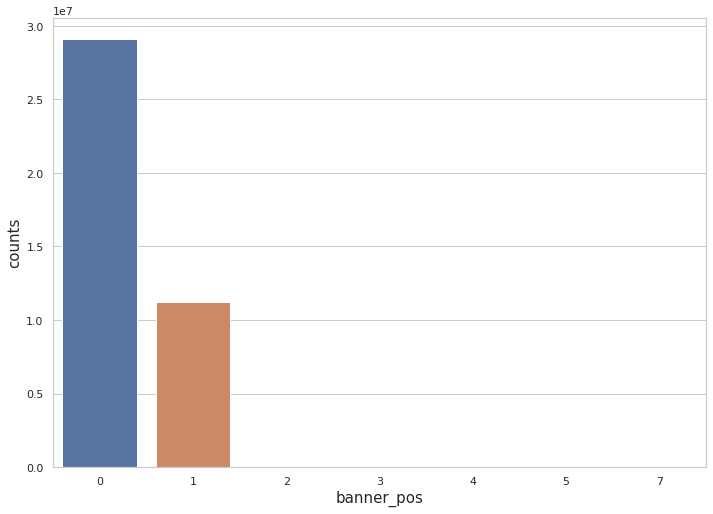

In [ ]:
import seaborn as sns
sns.set(style="whitegrid",rc={'figure.figsize':(11.7,8.27)})
b = sns.barplot(x = 'banner_pos',y = 'counts', data =  banner_pos_count)
b.set_xlabel('banner_pos', fontsize = 15);
b.set_ylabel('counts', fontsize = 15);

In [ ]:
# clicks vs non clicks
pdf_banner_position = spark.sql("""
                                with cte as (
                                  select banner_pos,
                                  sum(case when click = 1 then 1 else 0 end) as click,
                                  sum(case when click = 0 then 1 else 0 end) as no_click
                                  from impression 
                                  group by 1 
                                  order by 1
                                  )
                                select *,
                                      cte.click/(cte.click+cte.no_click) as click_rate
                                from cte
                                """).toPandas()
pdf_banner_position                           

,banner_pos,click,no_click,click_rate
0,0,4781901,24327689,0.164272
1,1,2065164,9182118,0.183614
2,2,1550,11451,0.119222
3,3,372,1663,0.182801
4,4,1428,6276,0.185358
5,5,702,5076,0.121495
6,7,13949,29628,0.320100


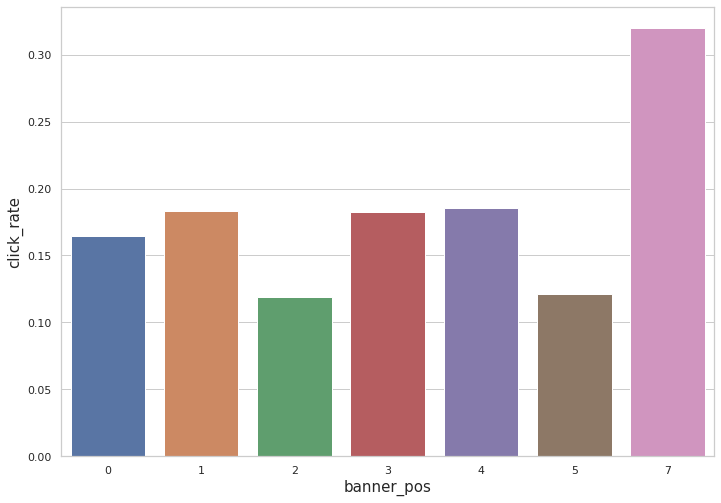

In [ ]:
import seaborn as sns
sns.set(style="whitegrid",rc={'figure.figsize':(11.7,8.27)})
b = sns.barplot(x ='banner_pos',y = 'click_rate', data =  pdf_banner_position)
b.set_xlabel('banner_pos', fontsize = 15);
b.set_ylabel('click_rate', fontsize = 15);

In [ ]:
ax = sns.barplot(x="banner_pos", y="total_bill", hue="sex", data=tips)

In [ ]:
g = sns.catplot(x="banner_pos", y="total_bill",
                hue="smoker", col="banner_pos",
                data=tips, kind="bar",
                height=4, aspect=.7);

## Device type

In [ ]:
# value counts for device type
device_type_count  = spark.sql("""
          select device_type, 
                  count(1) as counts
          from impression
          group by 1 
          order by 1
          """).toPandas()
device_type_count

,device_type,counts
0,0,2220812
1,1,37304667
2,2,31
3,4,774272
4,5,129185


Text(0, 0.5, 'counts')

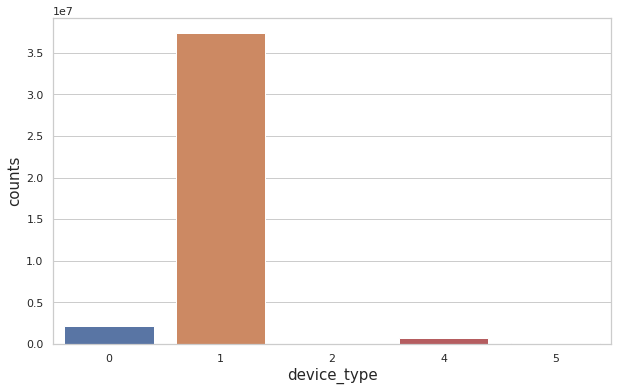

In [ ]:
import seaborn as sns
sns.set(style="whitegrid",rc={'figure.figsize':(10,6)})
b = sns.barplot(x = 'device_type',y = 'counts', data =  device_type_count)
b.set_xlabel('device_type', fontsize = 15)
b.set_ylabel('counts', fontsize = 15)

In [ ]:
#-- clicks vs non clicks within device_type
df_device_type = spark.sql("""
                            select device_type,
                            sum(case when click = 1 then 1 else 0 end) as click,
                            sum(case when click = 0 then 1 else 0 end) as no_click,
                            sum(case when click = 1 then 1 else 0 end) / (count(1) * 1.0) as click_rate
                            from impression 
                            group by 1 
                            order by 1
                            """).toPandas()
df_device_type                      

,device_type,click,no_click,click_rate
0,0,467995,1752817,0.21073148019733323
1,1,6311046,30993621,0.16917577631774598
2,2,2,29,0.06451612903225806
3,4,73900,700372,0.09544449495784427
4,5,12123,117062,0.09384216433796493


Text(0, 0.5, 'click_rate')

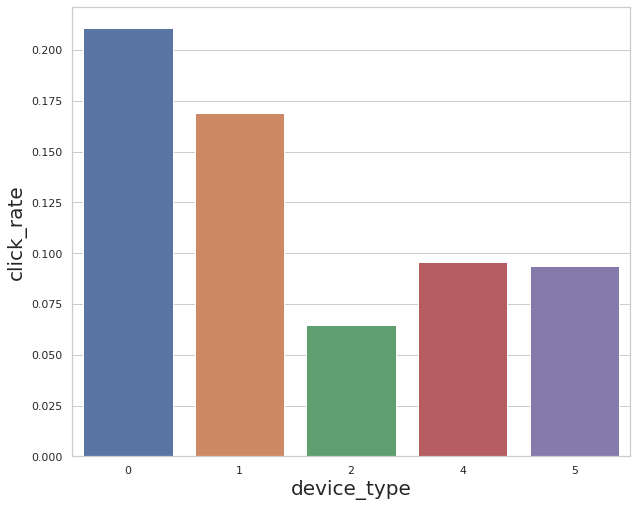

In [ ]:
import seaborn as sns
sns.set(style="whitegrid",rc={'figure.figsize':(10,8.27)})
b = sns.barplot(x = 'device_type',y = 'click_rate', data =  df_device_type)
b.set_xlabel('device_type', fontsize = 15)
b.set_ylabel('click_rate', fontsize = 15)

## Site_category

In [ ]:
# value counts
site_category = spark.sql("""
          select site_category, 
                  count(1) as count
          from impression
          group by 1 
          having count > 200 
          order by 1
          """).toPandas()
site_category

,site_category,count
0,0569f928,17106
1,28905ebd,7377208
2,335d28a8,136463
3,3e814130,3050306
4,42a36e14,2515
5,50e219e0,16537234
6,5378d028,483
7,70fb0e29,24224
8,72722551,28216
9,75fa27f6,160985


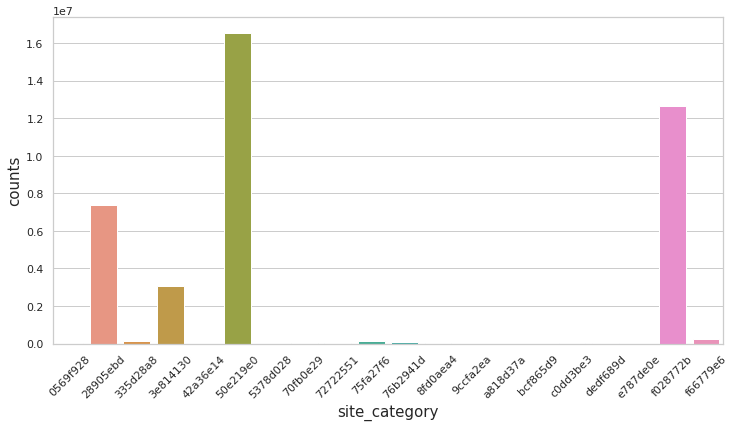

In [ ]:
import seaborn as sns
sns.set(style="whitegrid",rc={'figure.figsize':(12,6)})
b = sns.barplot(x = 'site_category',y = 'count', data =  site_category)
b.set_xlabel('site_category', fontsize = 15);
b.set_ylabel('counts', fontsize = 15);
plt.xticks(rotation=45);

In [ ]:
# clicks vs non clicks
df_site_category = spark.sql("""
                              select site_category,
                              count(1) as count,
                              sum(case when click = 1 then 1 else 0 end) as click,
                              sum(case when click = 0 then 1 else 0 end) as no_click,
                              sum(case when click = 1 then 1 else 0 end) / (count(1) * 1.0) as click_rate
                              from impression 
                              group by 1 
                              having count > 200 
                              order by 1
                              """).toPandas()
df_site_category                              

,site_category,count,click,no_click,click_rate
0,0569f928,17106,923,16183,0.05395767566935578
1,28905ebd,7377208,1534600,5842608,0.20801907713595713
2,335d28a8,136463,12779,123684,0.09364443109121154
3,3e814130,3050306,863245,2187061,0.28300275447774748
4,42a36e14,2515,581,1934,0.23101391650099404
5,50e219e0,16537234,2126350,14410884,0.12857954359235650
6,5378d028,483,46,437,0.09523809523809524
7,70fb0e29,24224,3298,20926,0.13614597093791281
8,72722551,28216,1626,26590,0.05762687836688404
9,75fa27f6,160985,17915,143070,0.11128365996832003


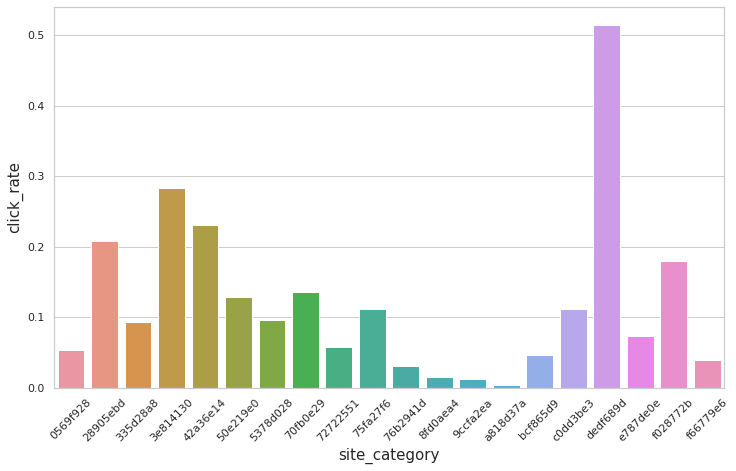

In [ ]:
import seaborn as sns
sns.set(style="whitegrid",rc={'figure.figsize':(12,7)})
b = sns.barplot(x = 'site_category',y = 'click_rate', data =  df_site_category)
b.set_xlabel('site_category', fontsize = 15)
b.set_ylabel('click_rate', fontsize = 15);
plt.xticks(rotation=45);

## Hour

In [ ]:
# value counts
hour = spark.sql("""
          select substr(hour, 7) as hour, 
                count(1) as count
          from impression 
          group by 1 
          order by 1
          """).toPandas()
hour

,hour,count
0,00,845178
1,01,984784
2,02,1222672
3,03,1399001
4,04,1913348
5,05,1982179
6,06,1762743
7,07,1857712
8,08,2096264
9,09,2276401


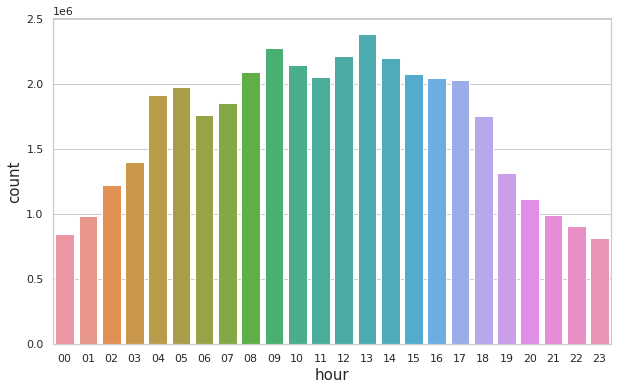

In [ ]:
import seaborn as sns
sns.set(style="whitegrid",rc={'figure.figsize':(10,6)})
b = sns.barplot(x = 'hour',y = 'count', data =  hour)
b.set_xlabel('hour', fontsize = 15);
b.set_ylabel('count', fontsize = 15);
plt.xticks(rotation=0);

In [ ]:
# -- clicks vs non clicks
df_hour = spark.sql("""
                    select substr(hour, 7) as hour,
                    sum(case when click = 1 then 1 else 0 end) as click,
                    sum(case when click = 0 then 1 else 0 end) as no_click,
                    sum(case when click = 1 then 1 else 0 end) / (count(1) * 1.0) as click_rate
                    from impression 
                    group by 1 
                    order by 1
                    
                    """).toPandas()
df_hour                  

,hour,click,no_click,click_rate
0,00,152429,692749,0.18035135793880106
1,01,182947,801837,0.18577373312320265
2,02,215322,1007350,0.17610773780703247
3,03,243705,1155296,0.17419930364595879
4,04,305308,1608040,0.15956741795010631
5,05,323863,1658316,0.16338736309889268
6,06,296346,1466397,0.16811639586712300
7,07,332884,1524828,0.17919031582936429
8,08,342120,1754144,0.16320463453076521
9,09,364461,1911940,0.16010404142328175


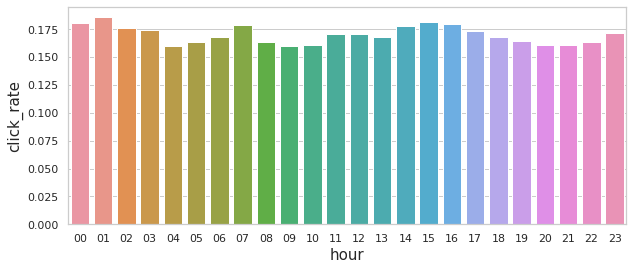

In [ ]:
import seaborn as sns
sns.set(style="whitegrid",rc={'figure.figsize':(10,4)})
b = sns.barplot(x = 'hour',y = 'click_rate', data =  df_hour)
b.set_xlabel('hour', fontsize = 15)
b.set_ylabel('click_rate', fontsize = 15);
plt.xticks(rotation=0);

## App_category

In [ ]:
# value counts
app_category_count = spark.sql("""
                              select app_category,
                                    count(1) as count

                              from impression
                              group by 1
                              order by 1
                              """).toPandas()
app_category_count

,app_category,count
0,07d7df22,26165592
1,09481d60,54886
2,0bfbc358,425
3,0d82db25,25
4,0f2161f8,9561058
5,0f9a328c,5584
6,18b1e0be,212
7,2281a340,2243
8,2fc4f2aa,234
9,4681bb9d,6291


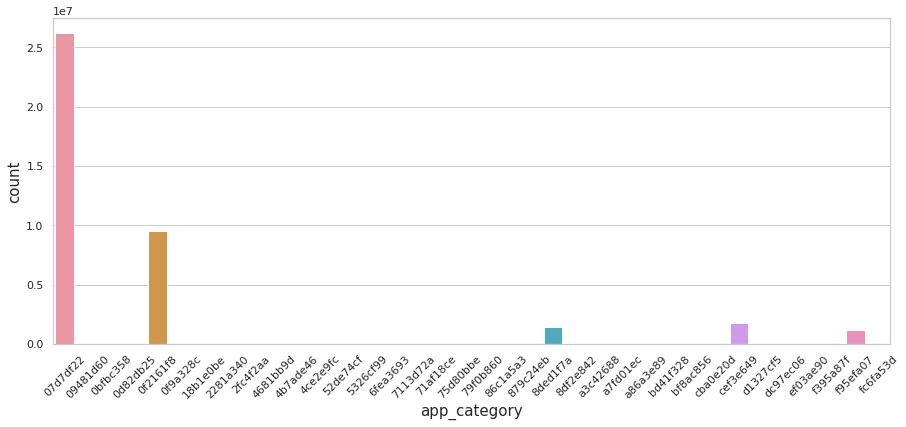

In [ ]:
import seaborn as sns
sns.set(style="whitegrid",rc={'figure.figsize':(15,6)})
b = sns.barplot(x = 'app_category',y = 'count', data =  app_category_count)
b.set_xlabel('app_category', fontsize = 15);
b.set_ylabel('count', fontsize = 15);
plt.xticks(rotation=45);

In [ ]:
print('clicks vs. no clicks')
df_app_category = spark.sql("""
                            select app_category,
                                    sum(case when click = 1 then 1 else 0 end) as click,
                                    sum(case when click = 0 then 1 else 0 end) as no_click,
                                    sum(case when click = 1 then 1 else 0 end)/( sum(case when click = 1 then 1 else 0 end)+ sum(case when click = 0 then 1 else 0 end)) as click_rate
                            from impression
                            group by 1
                            order by 1
                            """).toPandas()
df_app_category

clicks vs. no clicks


,app_category,click,no_click,click_rate
0,07d7df22,5210822,20954770,0.199148
1,09481d60,8518,46368,0.155194
2,0bfbc358,7,418,0.016471
3,0d82db25,4,21,0.160000
4,0f2161f8,1033720,8527338,0.108118
5,0f9a328c,867,4717,0.155265
6,18b1e0be,15,197,0.070755
7,2281a340,30,2213,0.013375
8,2fc4f2aa,4,230,0.017094
9,4681bb9d,908,5383,0.144333


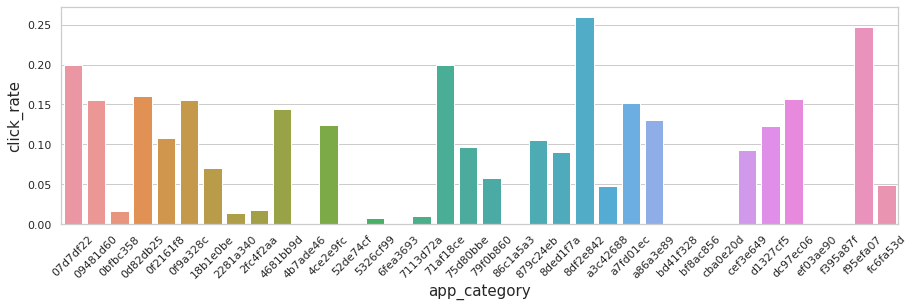

In [ ]:
import seaborn as sns
sns.set(style="whitegrid",rc={'figure.figsize':(15,4)})
b = sns.barplot(x = 'app_category',y = 'click_rate', data =  df_app_category)
b.set_xlabel('app_category', fontsize = 15)
b.set_ylabel('click_rate', fontsize = 15);
plt.xticks(rotation=45);

## c15

In [ ]:
c15_count = spark.sql("""
                      select C15,
                            count(1) as count
                      from impression
                      group by 1
                      order by 1
                      """).toPandas()
c15_count

,C15,count
0,120,3069
1,216,298794
2,300,2337294
3,320,37708959
4,480,2137
5,728,74533
6,768,1621
7,1024,2560


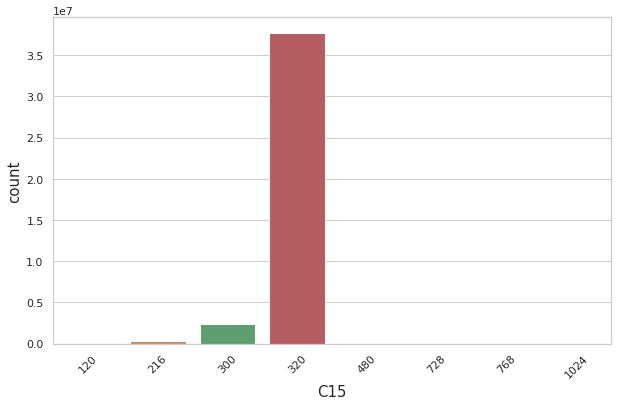

In [ ]:
import seaborn as sns
sns.set(style="whitegrid",rc={'figure.figsize':(10,6)})
b = sns.barplot(x = 'C15',y = 'count', data =  c15_count)
b.set_xlabel('C15', fontsize = 15);
b.set_ylabel('count', fontsize = 15);
plt.xticks(rotation=45);

In [ ]:
# clicks vs non clicks
df_C15 = spark.sql("""
                    select C15,
                            sum(case when click = 1 then 1 else 0 end) as click,
                            sum(case when click = 0 then 1 else 0 end) as no_click,
                            sum(case when click = 1 then 1 else 0 end)/( sum(case when click = 1 then 1 else 0 end)+ sum(case when click = 0 then 1 else 0 end)) as click_rate
                    from impression
                    group by 1
                    order by 1
                    """).toPandas()
df_C15

,C15,click,no_click,click_rate
0,120,58,3011,0.018899
1,216,37988,260806,0.127138
2,300,839925,1497369,0.359358
3,320,5980935,31728024,0.158608
4,480,572,1565,0.267665
5,728,4246,70287,0.056968
6,768,690,931,0.425663
7,1024,652,1908,0.254688


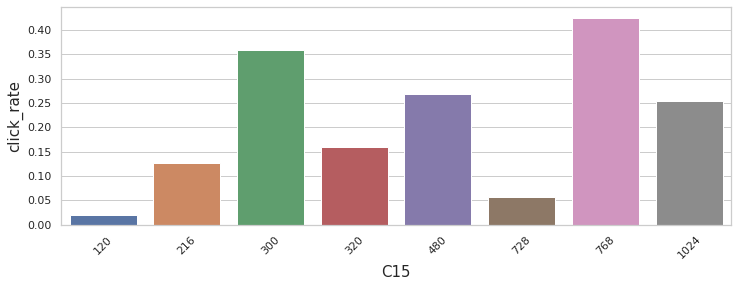

In [ ]:
import seaborn as sns
sns.set(style="whitegrid",rc={'figure.figsize':(12,4)})
b = sns.barplot(x = 'C15',y = 'click_rate', data =  df_C15)
b.set_xlabel('C15', fontsize = 15)
b.set_ylabel('click_rate', fontsize = 15);
plt.xticks(rotation=45);